# No target-specific binding

In [1]:
import numpy as np
import pandas as pd
import pyro
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import FormatStrFormatter
from pathlib import Path

from tapqir.models import Cosmos

## Load results

In [2]:
EXAMLES_DIR = Path.cwd().resolve().parent.parent.parent / "examples" / "data"

In [18]:
truth = {}
fit = {}
predictions = defaultdict(dict)
for data_path in EXAMLES_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("negative"):
        # load results
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        
        param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs4/"
        
        fit[data_path.name] = pd.read_csv(
            param_path / "statistics.csv",
            squeeze=True,
            index_col=0
        ).rename(data_path.name)
        fit[data_path.name]["lamda"] = truth[data_path.name]["lamda"]
        
        model = Cosmos()
        model.load(data_path, True)
        model.load_parameters(param_path)
        predictions[data_path.name]["z_all"] = model.z_marginal.flatten()

In [19]:
truth_df = pd.concat(truth.values(), axis=1).T.sort_values(by="lamda")
truth_df

,width,gain,pi,lamda,proximity,offset,height,background,snr,N,F,Nc,Fc,P
negative0.01,1.4,7.0,0.0,0.01,0.2,90.0,3000.0,150.0,3.758899,5.0,500.0,5.0,500.0,14.0
negative0.05,1.4,7.0,0.0,0.05,0.2,90.0,3000.0,150.0,3.758899,5.0,500.0,5.0,500.0,14.0
negative0.15,1.4,7.0,0.0,0.15,0.2,90.0,3000.0,150.0,3.758899,5.0,500.0,5.0,500.0,14.0
negative0.5,1.4,7.0,0.0,0.50,0.2,90.0,3000.0,150.0,3.758899,5.0,500.0,5.0,500.0,14.0
negative1,1.4,7.0,0.0,1.00,0.2,90.0,3000.0,150.0,3.758899,5.0,500.0,5.0,500.0,14.0


In [20]:
fit_df = pd.concat(fit.values(), axis=1).T.sort_values(by="lamda")
fit_df["converged"]

negative0.01    True
negative0.05    True
negative0.15    True
negative0.5     True
negative1       True
Name: converged, dtype: object

In [21]:
fit_df = fit_df.drop(columns=["converged"]).astype(float)
fit_df

,snr,gain_mean,gain_ll,gain_ul,pi_mean,pi_ll,pi_ul,lamda_mean,lamda_ll,lamda_ul,...,Recall,Precision,TN,FP,FN,TP,p(specific)_median,p(specific)_ll,p(specific)_ul,lamda
negative0.01,3.543571,7.034984,7.017546,7.055131,0.004198,0.001351,0.008792,0.007998,0.005542,0.011232,...,0.0,0.0,2493.0,7.0,0.0,0.0,0.0,0.0,0.0,0.01
negative0.05,NaN,7.021611,7.001163,7.041877,0.001283,0.000050,0.004712,0.053947,0.047363,0.060513,...,0.0,0.0,2500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05
negative0.15,NaN,7.020396,7.001756,7.040480,0.001261,0.000020,0.005648,0.159788,0.149108,0.171986,...,0.0,0.0,2500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15
negative0.5,NaN,7.023759,7.006126,7.046165,0.004256,0.000529,0.010335,0.500412,0.482074,0.520397,...,0.0,0.0,2500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50
negative1,NaN,7.058651,7.037881,7.078246,0.001861,0.000006,0.009006,0.960751,0.936790,0.987746,...,0.0,0.0,2500.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00


In [22]:
description = pd.Series(dtype=str, name="Description")
description["N"] = "Number of on-target AOIs"
description["F"] = "Number of frames for on-target AOIs"
description["Nc"] = "Number of control off-target AOIs"
description["Fc"] = "Number of frames for off-target AOIs"
description["P"] = "Number of pixels along x- and y-axes of an AOI"
description["height"] = "Spot intensity"
description["width"] = "Spot width"
description["snr"] = "Signal-to-noise ratio"
description["background"] = "Image background"
description["pi"] = "Average target-specific binding probability"
description["lamda"] = "Non-specific binding rate"
description["proximity"] = "Proximity parameter"
description["p(specific)"] = "Probability of there being any target-specific spot in an AOI image"
description["_ul"] = "95% CI upper-limit"
description["_ll"] = "95% CI lower-limit"
description["MCC"] = "Matthews correlation coefficient"
description["TP"] = "True positives"
description["FN"] = "False negatives"
description["TN"] = "True negatives"
description["FP"] = "False positives"
description

N                                       Number of on-target AOIs
F                            Number of frames for on-target AOIs
Nc                             Number of control off-target AOIs
Fc                          Number of frames for off-target AOIs
P                 Number of pixels along x- and y-axes of an AOI
height                                            Spot intensity
width                                                 Spot width
snr                                        Signal-to-noise ratio
background                                      Image background
pi                   Average target-specific binding probability
lamda                                  Non-specific binding rate
proximity                                    Proximity parameter
p(specific)    Probability of there being any target-specific...
_ul                                           95% CI upper-limit
_ll                                           95% CI lower-limit
MCC                      

## Supplementary Data 4

In [23]:
with pd.ExcelWriter("/home/ordabayev/repos/tapqir-overleaf/supplementary/data4/negative.xlsx") as writer:
    truth_df.to_excel(writer, sheet_name="simulation")
    fit_df.to_excel(writer, sheet_name="fit")
    description.to_excel(writer, sheet_name="description")

## Figure 5

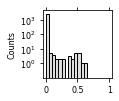

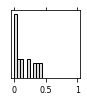

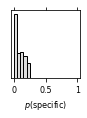

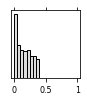

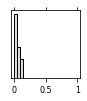

In [26]:
for name in fit_df.index:
    fig, ax = plt.subplots(figsize=(1.25, 1.25))
    ax.hist(predictions[name]["z_all"].numpy(),
             bins=np.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="#dddddd", edgecolor="k")
    ax.set_yscale("log")
    ax.set_xlim(-0.05,1.05)
    ax.set_ylim(1e-1, 5e3)
    ax.set_xticks([0, 0.5, 1])
    ax.tick_params(axis="x", labelsize=8, top=True)
    
    if name == "negative0.01":
        ax.set_ylabel("Counts", fontsize=8)
        ax.set_yticks([1, 10, 100, 1000])
        ax.tick_params(axis="y", labelsize=8)
    else:
        ax.set_yticks([])
        ax.tick_params(axis="y", labelsize=8)
    if name == "negative0.15":
        ax.set_xlabel(r"$p(\mathsf{specific})$", fontsize=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    # plt.savefig(f"/home/ordabayev/repos/tapqir-overleaf/figures/figure5/{name}.svg")
    plt.show()